# **EDA AND DATA CLEANING NOTEBOOK**

## Objectives

* Carry Out EDA relating to quality of data
* Clean data and save for use in further analysis

## Inputs

* **Raw Dataset:** inputs/datasets/raw/hotel_bookings.csv

## Outputs

* **Cleaned Dataset:** outputs/datasets/collection/cleaned/cleaned.csv

---

# Import Packages and Load Data

Imports

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Load data

In [ ]:
from pathlib import Path

project_root = Path.cwd().parent
dataset_file = project_root / 'inputs' / 'datasets' / 'raw' / 'hotel_bookings.csv'
df = pd.read_csv(dataset_file)
df.head(3)

---

# Convert Data Types

View current data types

In [ ]:
df.info()

Convert data types ready for profiling report.
- `Int64` allows for the missing values and is used for `children`, `agent` and `company` to remove decimal digits before converting to `category` type

In [ ]:
df['hotel'] = df['hotel'].astype('category')
df['is_canceled'] = df['is_canceled'].astype('bool')
df['arrival_date_year'] = df['arrival_date_year'].astype('category')
df['arrival_date_month'] = df['arrival_date_month'].astype('category')
df['children'] = df['children'].astype('Int64')
df['meal'] = df['meal'].astype('category')
df['country'] = df['country'].astype('category')
df['market_segment'] = df['market_segment'].astype('category')
df['distribution_channel'] = df['distribution_channel'].astype('category')
df['is_repeated_guest'] = df['is_repeated_guest'].astype('bool')
df['reserved_room_type'] = df['reserved_room_type'].astype('category')
df['assigned_room_type'] = df['assigned_room_type'].astype('category')
df['deposit_type'] = df['deposit_type'].astype('category')
df['agent'] = df['agent'].astype('Int64').astype('category')
df['company'] = df['company'].astype('Int64').astype('category')
df['customer_type'] = df['customer_type'].astype('category')
df['reservation_status'] = df['reservation_status'].astype('category')
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

df.info()

# Profile Report

In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df.drop_duplicates(), title="Hotel Bookings Profile Report", minimal=True)
profile.to_notebook_iframe()

The Profile Report alerts us to some possible data issues which require further exploration:
- **Data Ranges:**
  - `lead_time` shows two values over 600
  - `stays_in_weekend_nights` shows some values over 10
  - `stays_in_week_nights` shows some values over 30
  - `adults` shows some values over 20
  - `children` shows a high value of 10
  - `babies` shows high values of 9 and 10
  - `previous_cancellations` shows values over 20
  - `previous_bookings_not_canceled` shows values over 60
  - `booking_changes` shows values over 20
  - `days_in_waiting_list` shows values over 300
  - `adr` shows at least one negative value, many zero values and an incredibly high value of 5400
  - `required_car_parking_spaces` shows a high value of 8
- **Undefined Values for Categorical Variables:**
  - there are 'Undefined' values for `meal`, `market_segment`, `distribution_channel`
- **Missing Values**
  - there are missing values for `children`, `country`, `agent` and `company`

---

# Explore Statistical Outliers

## Functions to assist analysis

Define function for summarising value counts and percentages in a table

In [ ]:
def value_counts_and_percentages(df, filter_by_cols=None):
    data = df[filter_by_cols] if filter_by_cols else df
    df_count = data.value_counts(dropna=False)
    df_percent = round(data.value_counts(normalize=True, dropna=False) * 100, 1)
    summary = pd.concat([df_count, df_percent], axis=1)
    summary.columns = ['Count', '%']
    return summary

def plot_categorical_facets(data, x, facet_by, xlim=None):
    g = sns.catplot(data=data, x=x, kind="count", col=facet_by, col_wrap=2, sharey=False, hue=x, legend=False)
    for ax in g.axes.flatten():
        plt.setp(ax.get_xticklabels(), rotation=90)
    if xlim:
        plt.xlim(xlim)
    plt.show()

## Remove 'Undefined' Values

### Meal

View categories

In [ ]:
summary = value_counts_and_percentages(df, ['meal'])
summary

Drop 'Undefined'

In [ ]:
# Drop rows with values of 'Undefined'
condition = (df['meal'] == 'Undefined')
df = df[~condition]

# Check values have been dropped
summary = value_counts_and_percentages(df, ['meal'])
summary

### Market Segment

View categories

In [ ]:
summary = value_counts_and_percentages(df, ['market_segment'])
summary

Drop 'Undefined'

In [ ]:
# Drop rows with values of 'Undefined'
condition = (df['market_segment'] == 'Undefined')
df = df[~condition]

# Check values have been dropped
summary = value_counts_and_percentages(df, ['market_segment'])
summary

### Distribution Channel

View categories

In [ ]:
summary = value_counts_and_percentages(df, ['distribution_channel'])
summary

Drop 'Undefined'

In [ ]:
# Drop rows with values of 'Undefined'
condition = (df['distribution_channel'] == 'Undefined')
df = df[~condition]

# Check values have been dropped
summary = value_counts_and_percentages(df, ['distribution_channel'])
summary

## Lead Time

Show distribution

In [ ]:
sns.histplot(df, x='lead_time')

Analyse values over 600

In [ ]:
cols = ['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'stays_in_weekend_nights',
        'stays_in_week_nights', 'meal', 'market_segment', 'distribution_channel', 'agent', 'company','is_repeated_guest',
        'reserved_room_type','assigned_room_type', 'deposit_type', 'days_in_waiting_list',
        'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date']
cols = df.columns
data = df[df['lead_time'] > 600][cols].value_counts(dropna=False)
pd.DataFrame(data)

The bookings with lead times between 600 and 700 share a number of similarities:
- same hotel (City Hotel)
- same travel agent
- for off-peak seasons
- all group bookings
- same room type and meal plan
- adr within 58-63 range
- resulted in cancelled bookings

The bookings with lead times above 700 also share a number of similarities:
- same hotel (resort hotel)
- direct bookings
- were not cancelled

They are also both unusual in different ways:
- one has no overnight stays (either weekdays or weekends) and an adr of 0
  - NOTE: a deeper analysis of adr=0 follows later
- one has 28 overnight stays (i.e. 4 weeks)

These bookings do not appear to be random anomalies but rather coherent subsets of bookings. They are also not too much higher than other lead time values.

**ACTION:** keep all records

## Overnight Stays

Add a calculated `total_nights` variable to assist in analysis

In [ ]:
df_nights = df.copy().drop_duplicates()
df_nights['total_nights'] = df_nights['stays_in_weekend_nights'] + df['stays_in_week_nights']

### Check consistency between `stays_in_weekend_nights` and `stays_in_week_nights`

By calculating the weeks that a guest stayed using `stays_in_weekend_nights` and `stays_in_week_nights`, we can check that the difference is never greater than 1.

In [ ]:
# Create columns for weeks calculated by weekday nights and weekend nights
df_nights['weekend_weeks'] = df_nights['stays_in_weekend_nights'] / 2
df_nights['weekday_weeks'] = df_nights['stays_in_week_nights'] / 5

# If consistent, the difference between weekend_weeks and weekday_weeks should be <= 1
df_nights['weeks_are_consistent'] = (abs(df_nights['weekend_weeks'] - df_nights['weekday_weeks'])<=1)
df_nights['weeks_are_consistent'].value_counts()

All records have consistent values.

### Analyse highest values

Inspect records with long stays

In [ ]:
high_overnight_stays = df_nights[(df_nights['stays_in_weekend_nights']>10) | (df_nights['stays_in_week_nights']>30)]
high_overnight_stays

These observations all seem plausible. For example, there are no babies or children staying for this long. Some of the average daily rates are very low with 4 of the stays being without charge. This is presumably a concession for special guests.

### Zero Overnight Stays

Inspect records with no overnight stays

In [ ]:
no_overnight_stays = df_nights[(df_nights['total_nights']==0)]
no_overnight_stays

It is unclear what these bookings are but they are clearly a special case.

These bookings constitute less than 1% of the overall data (duplicates removed).

In [ ]:
summary = value_counts_and_percentages(df_nights, ['total_nights'])
summary.loc[[0.0]]

All of these records have **adr = 0**. According to the [original data source](https://www.sciencedirect.com/science/article/pii/S2352340918315191), Average Daily Rates are calculated by
> dividing the sum of all lodging transactions by the total number of staying nights.

If there are no staying nights, the value will be undefined and the system presumably defaults to zero.

In [ ]:
summary = value_counts_and_percentages(no_overnight_stays, ['adr'])
summary

Cancellation rates are much lower for this type of booking than overnight stays

In [ ]:
condition = df_nights['total_nights'] == 0.0

# Get percentage counts for day-only bookings and overnight bookings
day_only_counts = value_counts_and_percentages(df_nights[condition], ['is_canceled'])
overnight_counts = value_counts_and_percentages(df_nights[~condition], ['is_canceled'])

# Concatenate data into one summary table
summary = pd.concat([day_only_counts, overnight_counts], axis=1)

# Drop Counts and rename columns
summary.drop('Count', axis=1, inplace=True)
summary.columns = ['No Overnight Stays (%)', 'Yes Overnight Stays (%)']

summary

Of all bookings that have adr = 0.0, the majority of these do consist of at least one overnight stay (~63%) but bookings with no overnight stays still constitute a significant minority and therefore will not be removed for the moment.

In [ ]:
zero_adr = df_nights[df_nights['adr'] == 0.0]
summary = value_counts_and_percentages(zero_adr, ['total_nights'])
summary

## Adults

View values

In [ ]:
summary = value_counts_and_percentages(df.drop_duplicates(), ['adults'])
summary

Analyse records with more than 5 adults

In [ ]:
high_adults = df[df['adults'] > 5].drop_duplicates()
high_adults

These records share some similarities
- same hotel (Resort)
- booked for Sep and Oct in 2015
- booked over 300 days in advance
- group bookings
- many were booked through the same travel agent
- adr = 0
- country = PRT
- all were cancelled - most in Jan 2015 but one in Sep 2015

Since they were group bookings with other similarities, these records are valid and will not be removed. 

## Children

View values

In [ ]:
summary = value_counts_and_percentages(df.drop_duplicates(), ['children'])
summary

It is highly unlikely but not impossible that a booking involved 10 children

In [ ]:
df[df['children'] == 10]

View the distribution of ADR for the same room type

In [ ]:
room_D = df[df['assigned_room_type'] == 'D'].drop_duplicates()
sns.histplot(room_D, x='adr')

It is likely an anomaly because:
- Most hotels don’t allow a single room with 2 adults + 10 children so it was likely meant to say 1 or 0.
- ADR (133.16) looks like a normal rate for 1–2 rooms, not for such a large group.
- Reservation status = 'No-Show', which might explain why it slipped through without being corrected on arrival.

**ACTION:** drop

In [ ]:
condition = df['children'] == 10
df = df[~condition]

## Babies

View values

In [ ]:
summary = value_counts_and_percentages(df.drop_duplicates(), ['babies'])
summary

Inspect babies > 5

In [ ]:
df[df['babies'] > 5]

The rest of the details look to be consistent with small bookings. These are considered to be anomalies.

**ACTION:** drop

In [ ]:
condition = df['babies'] > 5
df = df[~condition]

## Previous Cancellations

View values

In [ ]:
summary = value_counts_and_percentages(df.drop_duplicates(), ['previous_cancellations'])
summary

Inspect records with high previous_cancellations

In [ ]:
high_cancellations = df[df['previous_cancellations'] > 15].drop_duplicates()
high_cancellations


View relationship between previous_cancellations and previous_bookings_not_canceled

In [ ]:
sns.scatterplot(df.drop_duplicates(), x='previous_cancellations', y='previous_bookings_not_canceled')

Guests who have very high cancellation rates are typically characterised by having no previous non-cancelled bookings and no other records after Oct 2015.

These are probably valid system records which were flagged by the hotel to prevent future bookings by these customers although they could represent a system design error (e.g. the same “guest” ID may be reused by an agent, inflating cancellation counts).

**ACTION:** keep

## Previous Bookings Not Cancelled

Inspect previous_bookings_not_canceled > 40

In [ ]:
df[df['previous_bookings_not_canceled'] > 40].drop_duplicates()


These bookings appear to be valid as they were all made to the City Hotel by the same company with low lead times.

**ACTION:** keep

## Booking Changes

View values

In [ ]:
summary = value_counts_and_percentages(df.drop_duplicates(), ['booking_changes'])
summary

In [ ]:
df[df['booking_changes'] > 15].drop_duplicates()

These do not look like random errors since there are similarities:
- All of these bookings are associated with a company or an agent (most are tied to agent 9 or agent 240, which may represent large travel agencies or corporate portals)
- Some of these are very long stays and these are more likely to require some booking changes

They could possibly be explained by agencies using "change" instead of cancel/rebook.

**ACTION:** keep

## Days in Waiting List

In [ ]:
summary = value_counts_and_percentages(df.drop_duplicates(), ['days_in_waiting_list'])
summary

In [ ]:
df[df['days_in_waiting_list'] > 300].drop_duplicates()

These look to be valid entries because they share the following similiarities:
- same hotel (City)
- group bookings by the same agent (1)
- high lead times

They reflect group reservations booked far in advance, held on a waiting list until confirmed.

**ACTION:** keep

## Average Daily Rates

A negative value for ADR is not valid

**ACTION:** drop

In [ ]:
condition = df['adr'] < 0
df = df[~condition]

View values

In [ ]:
summary = value_counts_and_percentages(df.drop_duplicates(), ['adr'])
summary

Approximately 2% of unduplicated records have **adr = 0** so it is worth more exploration.

In [ ]:
df_adr = df.copy().drop_duplicates()
df_adr['zero_adr'] = df_adr['adr'] == 0.0
df_adr['zero_adr'].value_counts(normalize=True)

### Distributions in Categorical Features

Look for differences in the distribution of categorical variables.

In [ ]:
cat_features = df_adr.select_dtypes(['category', 'bool']).columns.to_list()
for feature in cat_features:
    plot_categorical_facets(df_adr, feature, 'zero_adr')

View which agents booked the most zero-adr bookings

In [ ]:
df_adr[df_adr['zero_adr'] == True]['agent'].value_counts().head(3)

View which companies booked the most zero-adr bookings

In [ ]:
df_adr[df_adr['zero_adr'] == True]['company'].value_counts().head(3)

### Distributions in Numeric Features

View numeric features to investigate

In [413]:
numeric_features = df_adr.select_dtypes('number').columns.to_list()
print(numeric_features)

['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


View distributions of lead times

(0.0, 300.0)

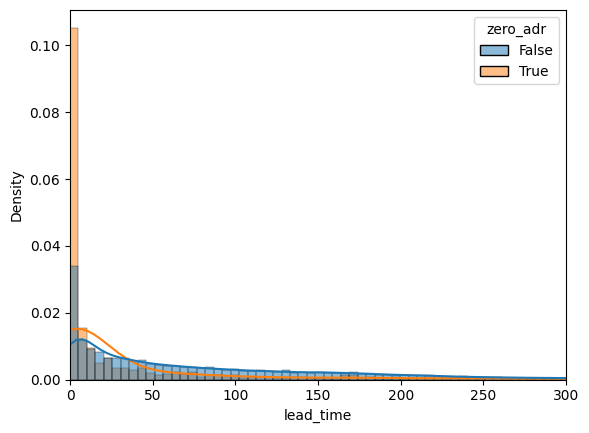

In [414]:
sns.histplot(df_adr, x='lead_time', hue='zero_adr', stat='density', common_norm=False, kde=True)
plt.xlim(0,300)

Bookings with zero-adr are much more likely to have zero lead time

In [415]:
df_zero = df_adr[df_adr['zero_adr']==True]
df_non_zero = df_adr[df_adr['zero_adr']==False]

zero_count = value_counts_and_percentages(df_zero, ['lead_time'])
non_zero_count = value_counts_and_percentages(df_non_zero, ['lead_time'])

summary = pd.concat([zero_count, non_zero_count], axis=1)
summary.drop('Count', axis=1, inplace=True)
summary.columns = ['zero-adr (%)', 'non zero-adr (%)']
summary

,zero-adr (%),non zero-adr (%)
lead_time,,
0,30.1,6.4
1,9.4,3.6
2,4.1,2.2
3,3.8,1.9
4,3.5,1.8
...,...,...
400,NaN,0.0
410,NaN,0.0
411,NaN,0.0


View duration of stay

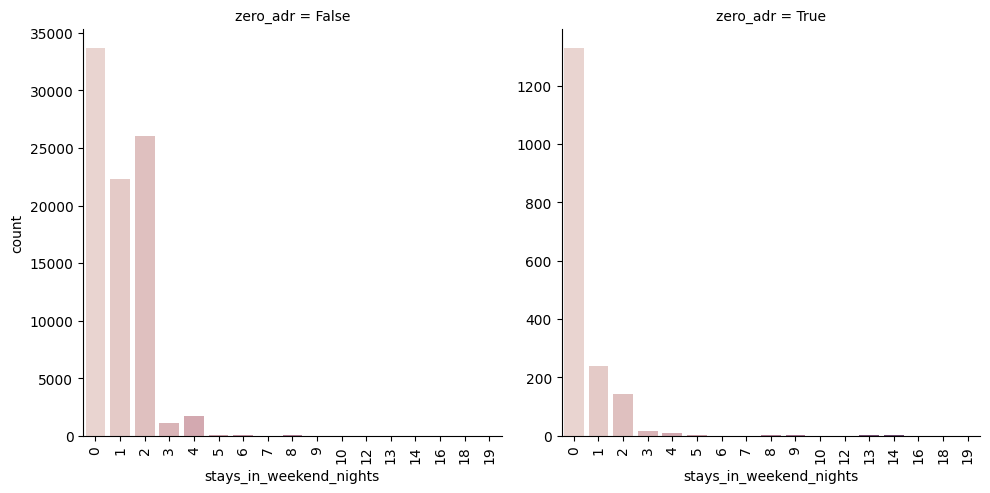

In [416]:
plot_categorical_facets(df_adr, 'stays_in_weekend_nights', 'zero_adr')

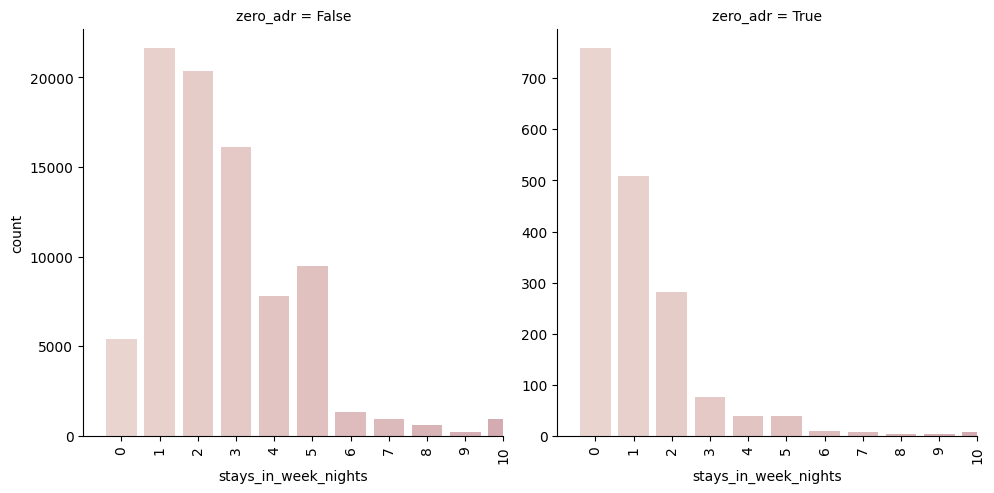

In [418]:
plot_categorical_facets(df_adr, 'stays_in_week_nights', 'zero_adr', (-1,10))

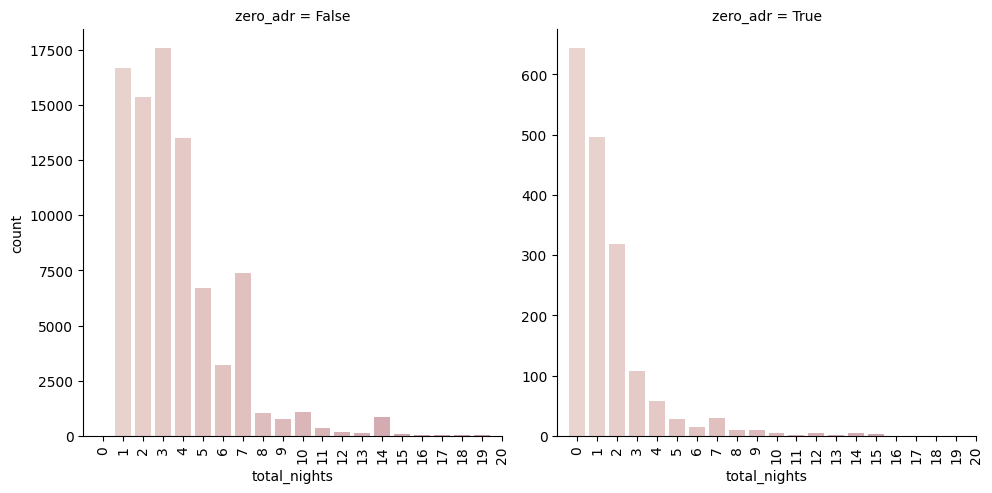

In [421]:
df_adr['total_nights'] = df_adr['stays_in_week_nights'] + df_adr['stays_in_weekend_nights']
plot_categorical_facets(df_adr, 'total_nights', 'zero_adr', (-1,20))

In [ ]:
for feature in numeric_features:
    sns.histplot(df_adr, x=feature, hue='zero_adr', stat='density', common_norm=False, kde=True)
    plt.show()

### Conclusions

Compared to standard bookings, bookings with zero ADR have:
- lower percentage cancellations
- higher percentage `is_repeated_guest`
- higher percentages in Oct and Dec for `arrival_date_month`
- higher percentages of 'Complementary' for `market_segment`
- higher percentages of 'Direct' for `distribution_channel`
- higher perentage of room I and K for `assigned_room_type`
- higher percentage for 240 for `agent`
- predominantly been booked through company 45
- higher occurences of zero lead time
- fewer overnight stays and a large proportion of zero overnight stays 

These patterns make it unlikely that they are random errors. It is more likely that zero ADR represents valid "non-revenue" bookings such as staff stays, promotions, group allotments or company-specific deals where revenue is not recorded at ADR level.

**ACTION:** Keep

## Car Parking

View values

In [422]:
summary = value_counts_and_percentages(df.drop_duplicates(), ['required_car_parking_spaces'])
summary

,Count,%
required_car_parking_spaces,,
0,79627,91.6
1,7235,8.3
2,28,0.0
3,3,0.0
8,2,0.0


Inspect required_car_parking_spaces > 5

In [ ]:
df[df['required_car_parking_spaces'] > 5]

,29045,29046
hotel,Resort Hotel,Resort Hotel
is_canceled,False,False
lead_time,26,138
arrival_date_year,2017,2017
arrival_date_month,March,March
arrival_date_week_number,11,12
arrival_date_day_of_month,14,19
stays_in_weekend_nights,0,2
stays_in_week_nights,5,2
adults,2,2


These are valid bookings because they are both corporate bookings classed under a `customer_type` of 'Transient-Party'.

**ACTION:** Keep

# Data Consistency Analysis

## Investigate Distribution Channel

### Initial Investigations

View values for `distribution_channel`

In [ ]:
summary = value_counts_and_percentages(df, ['distribution_channel'])
display(summary)

### `distribution_channel` + `agent`

We expect that when an **agent** is specified, **distribution_channel = TA/TO**

In [ ]:
data = df[~df['agent'].isna()]
summary = value_counts_and_percentages(data, ['distribution_channel'])
display(summary)

Findings
- **TA/TO** is expected:
  - This is the majority class with over 90% of all observations
  - ACTION: keep
- **Direct** is inconsistent:
  - Probably `distribution_channel` or `agent` is mis-labelled but impossible to know which.
  - ACTION: drop
- **Corporate** is possible:
  - Some corporate bookings are handled by travel agents (e.g. travel management companies).
  - ACTION: investigate further
- **GDS** is valid:
  - Many travel agents book via GDS.
  - ACTION: keep

Check that similar patterns are seen with both hotels

In [ ]:
# City
city_data = df[(~df['agent'].isna() & (df['hotel'] == 'City Hotel'))]
city_summary = value_counts_and_percentages(city_data, ['distribution_channel'])

# Resort
resort_data = df[(~df['agent'].isna() & (df['hotel'] == 'Resort Hotel'))]
resort_summary = value_counts_and_percentages(resort_data, ['distribution_channel'])

# Concatenate into one table and remove counts
summary = pd.concat([city_summary, resort_summary], axis=1)
summary.drop('Count', axis=1, inplace=True)

# Rename column headings and display
summary.columns = ['% of City Hotel Bookings', '% of Resort Hotel Bookings']
summary


Similar patterns are seen with both hotels so there don't seem to be issues with administrative errors in only one of the hotels.

Investigate `Corporate` further
- How many of the 1134 corporate bookings have a company ID specified alongside the travel agent?

In [ ]:
data = df[(~df['agent'].isna()) & (~df['company'].isna())]
summary = value_counts_and_percentages(data, ['distribution_channel'])
display(summary)

Findings
- Only 132 of the 1134 agent bookings assigned distribution_channel = corporate have a company ID associated with them (~12%)
- These may still be valid records where the company was not recorded
- ACTION: keep 'Corporate' but drop 'Direct'


In [ ]:
# Drop rows with specified agent but distribution_channel = 'Direct'
condition = (~df['agent'].isna()) & (df['distribution_channel'] == 'Direct')
df = df[~condition]

data = df[~df['agent'].isna()]
summary = value_counts_and_percentages(data, ['distribution_channel'])
display(summary)

### `distribution_channel` + `company`

We expect that when a **company** is specified, **distribution_channel = Corporate**

In [ ]:
data = df[~df['company'].isna()]
summary = value_counts_and_percentages(data, ['distribution_channel'])
display(summary)

Findings
- **Corporate** is expected:
  - This is the majority class with ~ 75% of all observations
  - ACTION: keep
- **TA/TO** is possible:
  - Some corporate bookings are handled by travel agents (e.g. travel management companies).
  - ACTION: keep
- **Direct** is inconsistent:
  - Probably `distribution_channel` or `company` is mis-labelled but impossible to know which.
  - ACTION: drop
- **GDS** is possible:
  - The company could have booked via GDS.
  - ACTION: keep

In [ ]:
# Drop rows with specified company but distribution_channel = 'Direct'
condition = (~df['company'].isna()) & (df['distribution_channel'] == 'Direct')
df = df[~condition]

data = df[~df['company'].isna()]
summary = value_counts_and_percentages(data, ['distribution_channel'])
display(summary)

## Investigate `is_canceled`

We expect that records with **is_canceled = 0** should have **reservation_status = 'Check-Out'**

In [ ]:
data = df[df['is_canceled']==0]
summary = value_counts_and_percentages(data, ['reservation_status'])
display(summary)

This is the case. We also expect that records with **is_canceled = 1** should have **reservation_status = 'Canceled' or 'No-Show'**

In [ ]:
data = df[df['is_canceled']==1]
summary = value_counts_and_percentages(data, ['reservation_status'])
display(summary)

This is also the case so no cleaning required here.

## Investigate `is_repeated_guest`

This variable should relate to `previous_bookings_not_canceled` and `previous_cancellations` so these will each be investigated first.

### Investigate `previous_bookings_not_canceled`

According to the [original data source](https://www.sciencedirect.com/science/article/pii/S2352340918315191), this variable was assigned as follows:
> In case there was no customer profile associated with the booking, the value is set to 0. Otherwise, the value is the number of bookings with the same customer profile created before the current booking and not canceled.

Presumably this also applies to bookings made before the date range of the current dataset.

View counts

In [ ]:
data = df.drop_duplicates(keep='first')  # Drop duplicates to prevent skewing the data
summary = value_counts_and_percentages(data, ['previous_bookings_not_canceled'])
display(summary)

### Investigate `previous_cancellations`

According to the [original data source](https://www.sciencedirect.com/science/article/pii/S2352340918315191), this variable was assigned as follows:
> In case there was no customer profile associated with the booking, the value is set to 0. Otherwise, the value is the number of bookings with the same customer profile created before the current booking and canceled.

Presumably this also applies to bookings made before the date range of the current dataset.

In [ ]:
data = df.drop_duplicates(keep='first')  # Drop duplicates to prevent skewing the data
summary = value_counts_and_percentages(data, ['previous_cancellations'])
display(summary)

### Investigate `is_repeated_guest`

According to the [original data source](https://www.sciencedirect.com/science/article/pii/S2352340918315191), this variable was

> *"created by verifying if a profile was associated with the booking customer. If so, and if the customer profile creation date was prior to the creation date for the booking on the PMS database it was assumed the booking was from a repeated guest."*

Create a `total_previous_bookings` column

In [ ]:
df_prev_bookings = df.drop_duplicates(keep='first')
df_prev_bookings['total_previous_bookings'] = df_prev_bookings['previous_bookings_not_canceled'] + df_prev_bookings['previous_cancellations']
df_prev_bookings.head(3)


We expect that all records with **is_repeated_guest = 0** will have no previous non-cancelled bookings but this is not found to be the case.

In [ ]:
data = df_prev_bookings[df_prev_bookings['is_repeated_guest']==0]
summary = value_counts_and_percentages(data, ['total_previous_bookings', 'previous_bookings_not_canceled', 'previous_cancellations', 'is_repeated_guest'])
display(summary)

We expect that all records with **is_repeated_guest = 1** will have at least one previous non-cancelled booking but this is not found to be the case either. 

In [ ]:
data = df_prev_bookings[df_prev_bookings['is_repeated_guest']==1]
summary = value_counts_and_percentages(data, ['total_previous_bookings', 'previous_bookings_not_canceled', 'previous_cancellations', 'is_repeated_guest'])
display(summary)

Since the is_repeated_guest feature is derived from whether the PMS had a guest profile created before the booking (rather than using the previous booking data), the discrepancy may have predictive power when training the model.
- ACTION: add an additional feature (an inconsistency flag) during feature engineering and assess feature importance after training the model to see if the signal has any significance.